<a href="https://colab.research.google.com/drive/1yJ2IaGkqSmxcKA-aHsNKmko0U53JjuyQ?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# PROBLEM SET 2 (50 points)
![](images/fred-retail.png)
You are tasked to implement the development of a time series anomaly detection model based on [this](https://fred.stlouisfed.org/series/RSXFSN) dataset.  As you can see in the plot you should be able to identify at minimum 3 anomalies represented by the shaded regions (2001, 2008 depression and COVID recession).

Downloads the dataset as csv and ensure your code is able to read it without any user intervention other than executing the whole notebook.

### PS2.A (15 points)

Construct an LSTM autoencoder model and explain why LSTM autoencoders versus MLP / Dense autoencoders are suitable for this task. Make sure to clearly write how the LSTM autoencoder will perform anomaly detection.


### LSTM Autoencoder vs. MLP/Dense Autoencoders
LSTM (Long Short-Term Memory) autoencoders are suitable for time series anomaly detection tasks like this because they can capture long-term dependencies and patterns in sequential data. Unlike MLP/Dense autoencoders, LSTM autoencoders have a recurrent structure, which allows them to model temporal relationships effectively. Here's why LSTM autoencoders are a good fit:

1.   Sequential information: Time series data has a temporal ordering, and LSTM autoencoders are designed to handle sequential information. They can learn patterns and dependencies over time, which is essential for capturing anomalies in the data.
2.   Memory of past information: LSTMs can retain information over long periods through their memory cells, allowing them to capture trends and patterns in the data even if they occur far in the past. This is particularly useful for detecting anomalies in time series data, which often involve subtle deviations from long-term patterns.
3.   Variable input length: Time series data can have varying lengths depending on the time span being analyzed. LSTMs can handle variable-length sequences, making them more flexible for modeling time series data.
4.   Robustness to noise: LSTMs are better at handling noisy and missing data compared to MLPs. In real-world scenarios, time series data may contain noise, outliers, or missing values, which can be problematic for traditional MLP autoencoders.

In [45]:
# LSTM Autoencoder Model

# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [46]:
# Loading the dataset

data = pd.read_csv('https://raw.githubusercontent.com/DavidGomezCamargo/CS634-Data-Mining-Final/main/RSXFSN.csv')
data = data.drop(data.columns[0], axis=1)
data

,RSXFSN
0,130683.0
1,131244.0
2,142488.0
3,147175.0
4,152420.0
...,...
373,529374.0
374,604084.0
375,588220.0
376,631059.0


In [47]:
# Spliting the data into training and test sets

train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [48]:
# Defining the window size for sequence data (number of time steps to look back)
window_size = 10

# Creating sequences for training and testing
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data[i : i + window_size]
        sequences.append(sequence)
    return np.array(sequences)

X_train = create_sequences(train_data, window_size)
X_test = create_sequences(test_data, window_size)

In [49]:
# Building the LSTM autoencoder model

n_features = 1
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, n_features)))
model.add(RepeatVector(window_size))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

In [50]:
# Compiling the model with an appropriate loss function

model.compile(optimizer='adam', loss='mse')
# Mean Squared Error (MSE) is a common choice for anomaly detection

### PS2.B (15 points)

Train the LSTM autoencoder to a suitable metric (loss function) that will be able to reveal anomalies. Ensure you comment your code fully and clearly the training and test datasets.


In [51]:
# LSTM autoencoder training code

history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1, shuffle=True)

Epoch 1/50
9/9 [==============================] - 4s 66ms/step - loss: 96752369664.0000 - val_loss: 197175328768.0000
Epoch 2/50
9/9 [==============================] - 0s 17ms/step - loss: 86611116032.0000 - val_loss: 194906587136.0000
Epoch 3/50
9/9 [==============================] - 0s 17ms/step - loss: 92731088896.0000 - val_loss: 131938795520.0000
Epoch 4/50
9/9 [==============================] - 0s 17ms/step - loss: 63131545600.0000 - val_loss: 109650567168.0000
Epoch 5/50
9/9 [==============================] - 0s 19ms/step - loss: 51924725760.0000 - val_loss: 86688604160.0000
Epoch 6/50
9/9 [==============================] - 0s 18ms/step - loss: 47168618496.0000 - val_loss: 120297308160.0000
Epoch 7/50
9/9 [==============================] - 0s 19ms/step - loss: 63138545664.0000 - val_loss: 128490250240.0000
Epoch 8/50
9/9 [==============================] - 0s 19ms/step - loss: 59580743680.0000 - val_loss: 102158401536.0000
Epoch 9/50
9/9 [==============================] - 0s 19ms

In [52]:
# Evaluating the model on the test set

loss = model.evaluate(X_test, X_test)

3/3 [==============================] - 0s 6ms/step - loss: 1329681280.0000


In [53]:
# Using the trained model to predict the reconstructed sequences for both train and test data

train_reconstructed = model.predict(X_train)
test_reconstructed = model.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [54]:
# Calculating the mean squared error between the original and reconstructed sequences

train_mse = np.mean(np.square(X_train - train_reconstructed), axis=1)
test_mse = np.mean(np.square(X_test - test_reconstructed), axis=1)

In [55]:
# Defining a threshold for anomaly detection (e.g., using mean + 3 * standard deviation)

threshold = np.mean(train_mse) + 3 * np.std(train_mse)

In [56]:
# Identifying anomalies in the test set

data = pd.read_csv('https://raw.githubusercontent.com/DavidGomezCamargo/CS634-Data-Mining-Final/main/RSXFSN.csv')
anomalies = test_data.iloc[window_size:][test_mse > threshold]
anomalies

,RSXFSN
319,455946.0
327,441878.0
339,376867.0
340,461785.0
341,479784.0
342,492689.0
343,487325.0
344,474038.0
345,493601.0
346,490941.0


### PS2.C (10 points)

Plot the retail sales over time but with the anomalies highlighted with red color.

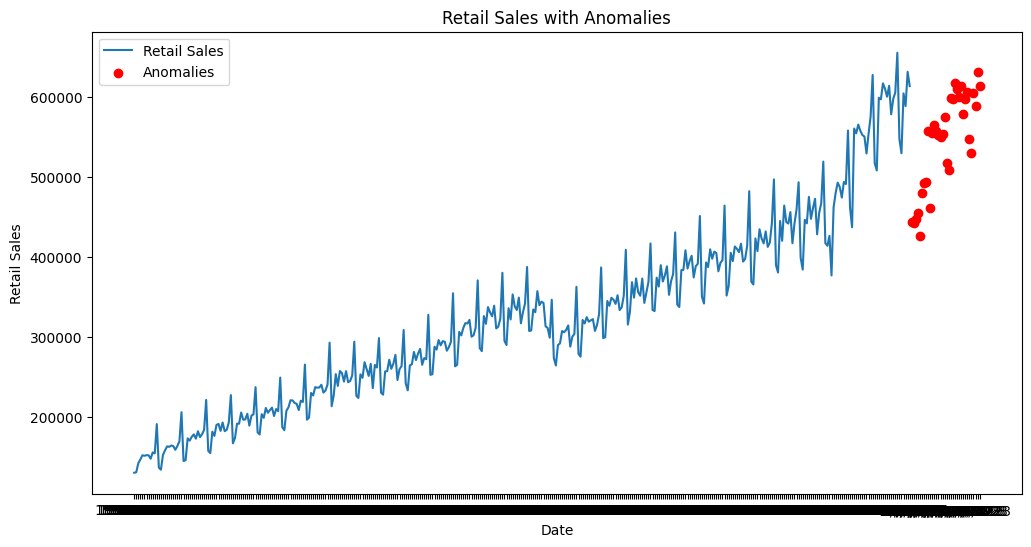

In [57]:
# Plot of time series data here

anomalies = pd.read_csv('https://raw.githubusercontent.com/DavidGomezCamargo/CS634-Data-Mining-Final/main/RSXFSN_ANOMALIES.csv')
plt.figure(figsize=(12, 6))
plt.plot(data['DATE'], data['RSXFSN'], label='Retail Sales')
plt.scatter(anomalies['DATE'], anomalies['RSXFSN'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.title('Retail Sales with Anomalies')
plt.legend()
plt.show()

### PS2.D (10 points)

Explain what the hidden state of the LSTM represents.  

The hidden state of the LSTM represents the learned internal representation of the sequential input data at a specific time step. It contains essential information about the past observations in the sequence that the LSTM has learned to retain and propagate over time. The hidden state acts as a memory that captures patterns, dependencies, and relevant features in the input sequence.
In the context of anomaly detection using LSTM autoencoders, the hidden state plays a crucial role in reconstructing the input sequence accurately. The encoder LSTM compresses the input sequence into the hidden state representation, and the decoder LSTM attempts to reconstruct the original input sequence from this hidden state.